# Аналитика в Яндекс.Афише

Яндекс.Афиша — это сервис, где можно узнать о событиях в городе и купить билеты в кино и на мероприятие. Расписание, анонсы и описание мероприятий предоставляют партнеры Яндекса и организаторы мероприятий. 

Имеются в распоряжении данные сервиса с июня 2017 по конец мая 2018 года:

* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Необходимо изучить:

* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент,
* на сколько эффективны рекламные источники.


## Содержание

 1. [Описание данных](#step1)  
 2. [Изучение данных](#step2)  
 3. [Предобработка данных](#step3)    
 4. [Анализ данных](#step4)
 5. [Портрет пользователей](#step5)
 6. [Проверка гипотез](#step6)  
 7. [Общие выводы](#step7)

## Описание данных<a id="step1"></a> 

**Лог сервера с информацией о посещениях сайта**


* ***Uid*** — уникальный идентификатор пользователя
* ***Device*** — категория устройства пользователя
* ***Start Ts*** — дата и время начала сессии
* ***End Ts*** — дата и время окончания сессии
* ***Source Id*** — идентификатор рекламного источника, из которого пришел пользователь


**Информация о заказах:**


* ***Uid*** — уникальный id пользователя, который сделал заказ
* ***Buy Ts*** — дата и время заказа
* ***Revenue*** — выручка Яндекс.Афиши с этого заказа


**Информация о затратах на маркетинг:**


* ***source_id*** — идентификатор рекламного источника
* ***dt*** — дата
* ***costs*** — затраты на этот рекламный источник в этот день

## Изучение данных <a id="step2"></a> 

In [1]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
#загружаем данные
visits=pd.read_csv('/datasets/visits_log.csv')
orders=pd.read_csv('/datasets/orders_log.csv')
costs=pd.read_csv('/datasets/costs.csv')

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Наименования перменных начинаются с верхнего регистра, для дальнейшего удобства работы с данными необходимо будет привести названия столбцов к нижнему регистру, а также избавиться от пробелов.

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Переменные даты и времени начала и окнчания сессии необходимо будет привести к соответсвующему типу данных *date time*. Пропущенные значения отсутствуют.

In [5]:
#проверка наличия дублирующих строк
visits.duplicated().sum()

0

In [6]:
#проверка дублирующих значений в наименовании категории устройства
visits['Device'].unique()

array(['touch', 'desktop'], dtype=object)

Дублирующие строки и значения отсутсвуют.

In [7]:
#проверка наличия аномальных значений
visits[visits['End Ts'] < visits['Start Ts']]

,Device,End Ts,Source Id,Start Ts,Uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


В данных о посещениях сайта есть два наблюдения, где время начала сеанса позже времени его окончания, что не может отражать реальную картину. Вероятно, при выгрузке данных произошла техническая ошибка. Учитывая, что таких строк всего 2 из 359400, данные наблюдения можно удалить без какого-либо сущетсвенного искажения дальнейших результатов исследования.

In [8]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Наименования перменных начинаются с верхнего регистра, для дальнейшего удобства работы с данными необходимо будет привести названия столбцов к нижнему регистру.

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Переменную даты и времени покупки необходимо будет привести к соответсвующему типу данных *date time*. Пропущенные значения отсутствуют.

In [10]:
#проверка наличия дублирующих строк
visits.duplicated().sum()

0

Дублирующие строки отсутствуют.

In [11]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Переменную даты необходимо привести к соответсвующему типу данных date time.

In [13]:
costs.duplicated().sum()

0

Дублирующие строки отсутствуют.

### Вывод

В результате первичного изучения данных таблиц пропущенные и дублирующие значения не были обнаружены, однако на этапе предобработки необходимо:

   - наименования переменных, где необходимо, привести к нижнему регистру;
   - перменнные даты  привести к соответсвующему типу данных;
   - удалить аномальные значения, где время начала сессии позже её окончания
  

## Предобработка данных <a id="step3"></a> 

* **Приведение наименования перменных к нижнему регистру и замена пробелов**

In [14]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()

In [15]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [16]:
orders.columns = ['buy_ts', 'revenue', 'uid']

* **Замена типа данных на соответсвующий**

In [17]:
visits['end_ts']=pd.to_datetime(visits['end_ts'])
visits['start_ts']=pd.to_datetime(visits['start_ts'])
orders['buy_ts']=pd.to_datetime(orders['buy_ts'])
costs['dt']=pd.to_datetime(costs['dt'])

* **Удаление аномальных значений**

In [18]:
#создаем срез, который включает только корректные наблюдения
visits=visits.query('end_ts>=start_ts')

### Вывод

На данном этапе мы переименовали названия переменных для дальнейшего удобства их использования, заменили тип данных, где это было необходимо, а также исключили наблюдения с аномальными значениями. Теперь, данные подготовлены для дальнейшего исследования и анализа.

## Анализ данных<a id="step4"></a> 

In [19]:
visits['start_ts'].describe()

count                  359398
unique                 224301
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

В базе содержатся данные о посещениях сайта в период с 1 июня 2017 по 31 мая 2018 года, то есть в течение 1 года. 

In [20]:
#извлекем из даты посещений необходимые единицы
visits['date']= visits['start_ts'].dt.date
visits['day'] = visits['start_ts'].dt.weekday
visits['month'] = visits['start_ts'].dt.strftime('%Y-%m') 
visits['week'] = visits['start_ts'].dt.week

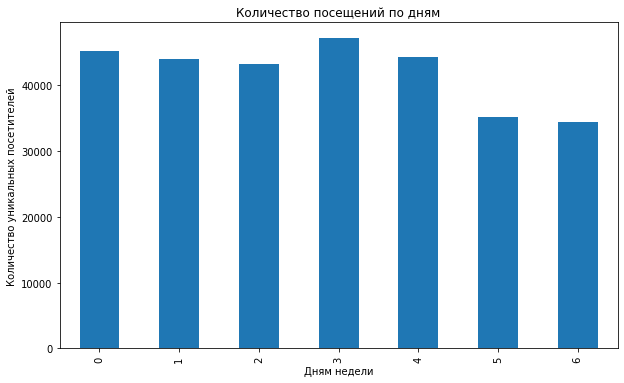

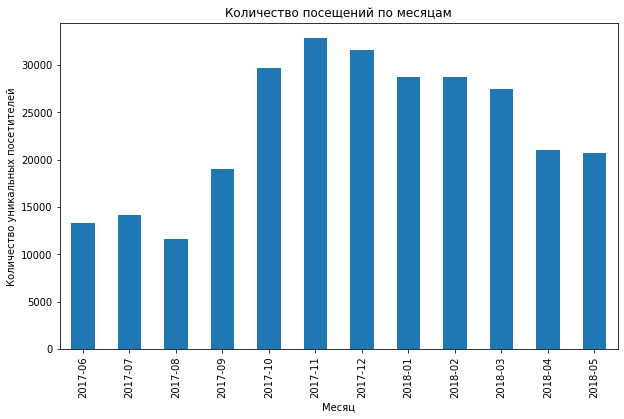

In [21]:
dict_label= {'day':{'title':'Количество посещений по дням','xlabel':'Дням недели'},
             'month':{'title':'Количество посещений по месяцам','xlabel':'Месяц'}}           

for key, value in dict_label.items():
    visits.groupby([key]).agg({'uid': 'nunique'}).plot(kind='bar',figsize=(10,6))
    plt.xlabel(value['xlabel'])
    plt.ylabel('Количество уникальных посетителей')
    plt.title(value['title'])
    plt.legend().remove()
    plt.show()

На графике можно заметить, что наибольшее количество посещений обычно наблюдается в четверг, что ожидаемо, так как люди примерно к концу рабочей недели начинают задумываться, о том как организовать свой досуг в пятницу вечером и на выходных, а значит спрос на сервис Яндекс.Афиша заметно увеличивается. В выходные, также ожидаемо наблюдается снижение спроса, потому что как правило пользователи редко покупают билеты на мероприятия день в день.

Что касается спроса в течение года, то сервисом больше всего пользуются с октября по декабрь, самая низкая востребованность зафиксирована в летний период. Вероятно, с октября по декабрь пользователи планируют педпразничный и праздничный новогодний досуг, что же касается летнего периода, обычно в это время проводится достаточно много фестивалей, билеты на которые чаще всего раскупаются еще весной и нет каких либо предпосылок ожидать высокого интереса со стороны пользователей в данное время года.

### Продукт

* **Сколько людей пользуются в день, неделю, месяц?**

In [22]:
dau_total = visits.groupby(['date']).agg({'uid': 'nunique'}).mean()
print('Среднее количество пользователей в день (DAU): {0:.0f}'.format(dau_total[0]))

wau_total = visits.groupby(['week']).agg({'uid': 'nunique'}).mean()
print('Среднее количество пользователей в неделю (WAU): {0:.0f}'.format(wau_total[0]))

mau_total = visits.groupby(['month']).agg({'uid': 'nunique'}).mean()
print('Среднее количество пользователей в месяц (MAU): {0:.0f}'.format(mau_total[0]))


Среднее количество пользователей в день (DAU): 908
Среднее количество пользователей в неделю (WAU): 5825
Среднее количество пользователей в месяц (MAU): 23228


In [23]:
sticky_mau = dau_total/mau_total
sticky_wau = dau_total/wau_total
print('DAU/MAU: {0:.1%}'.format( sticky_mau[0]))
print('DAU/WAU: {0:.1%}'.format(sticky_wau[0]))

DAU/MAU: 3.9%
DAU/WAU: 15.6%


В месяц около 3.9% пользователей, который пользуются сервисом Яндекс.Афиша каждый день. В неделю же - около 15.6% пользователей, заходящих на сайт на ежедневной основе. 


Посмотрим на sticky factor в разрезе используемого устройства. Для начала для каждого типа устройства рассчитаем DAU, WAU, MAU.

In [24]:
dau_total_d = visits.query('device=="desktop"').groupby(['date']).agg({'uid': 'nunique'}).mean()
print('Среднее количество пользователей в день на десктопе (DAU): {0:.0f}'.format(dau_total[0]))

wau_total_d = visits.query('device=="desktop"').groupby(['week']).agg({'uid': 'nunique'}).mean()
print('Среднее количество пользователей в неделю на десктопе (WAU): {0:.0f}'.format(wau_total[0]))

mau_total_d = visits.query('device=="desktop"').groupby(['month']).agg({'uid': 'nunique'}).mean()
print('Среднее количество пользователей в месяц на десктопе (MAU): {0:.0f}'.format(mau_total[0]))


Среднее количество пользователей в день на десктопе (DAU): 908
Среднее количество пользователей в неделю на десктопе (WAU): 5825
Среднее количество пользователей в месяц на десктопе (MAU): 23228


In [25]:
dau_total_t = visits.query('device=="touch"').groupby(['date']).agg({'uid': 'nunique'}).mean()
print('Среднее количество пользователей в день на touch (DAU): {0:.0f}'.format(dau_total[0]))

wau_total_t = visits.query('device=="touch"').groupby(['week']).agg({'uid': 'nunique'}).mean()
print('Среднее количество пользователей в неделю на touch  (WAU): {0:.0f}'.format(wau_total[0]))

mau_total_t = visits.query('device=="touch"').groupby(['month']).agg({'uid': 'nunique'}).mean()
print('Среднее количество пользователей в месяц на touch (MAU): {0:.0f}'.format(mau_total[0]))


Среднее количество пользователей в день на touch (DAU): 908
Среднее количество пользователей в неделю на touch  (WAU): 5825
Среднее количество пользователей в месяц на touch (MAU): 23228


In [26]:
sticky_mau_d = dau_total_d/mau_total_d
sticky_wau_d = dau_total_d/wau_total_d
print('DAU/MAU desktop: {0:.1%}'.format( sticky_mau_d[0]))
print('DAU/WAU desktop: {0:.1%}'.format(sticky_wau_d[0]))

DAU/MAU desktop: 3.9%
DAU/WAU desktop: 15.7%


In [27]:
sticky_mau_t = dau_total_t/mau_total_t
sticky_wau_t = dau_total_t/wau_total_t
print('DAU/MAU touch: {0:.1%}'.format( sticky_mau_t[0]))
print('DAU/WAU touch: {0:.1%}'.format(sticky_wau_t[0]))

DAU/MAU touch: 3.7%
DAU/WAU touch: 15.2%


Процент пользоваталей,использующих сервис каждый день в месяц (неделю) на мобильных устройствах ниже в сравнении с десктопом, однако не значительно.

* **Сколько сессий в день?**

In [28]:
session=visits.groupby('date').agg({'uid': 'count'}).mean()
print('Среднее количество сессий в день: {0:.2f}'.format(session[0]))


Среднее количество сессий в день: 987.36


In [29]:
session_touch=visits.query('device=="touch"').groupby('date').agg({'uid': 'count'}).mean()
print('Среднее количество сессий в день на мобильных устройствах: {0:.2f}'.format(session_touch[0]))

Среднее количество сессий в день на мобильных устройствах: 266.76


In [30]:
session_desk=visits.query('device=="desktop"').groupby('date').agg({'uid': 'count'}).mean()
print('Среднее количество сессий в день на десктопе: {0:.2f}'.format(session_desk[0]))

Среднее количество сессий в день на десктопе: 721.33


In [31]:
desk_share=session_desk/session*100
touch_share=100-desk_share

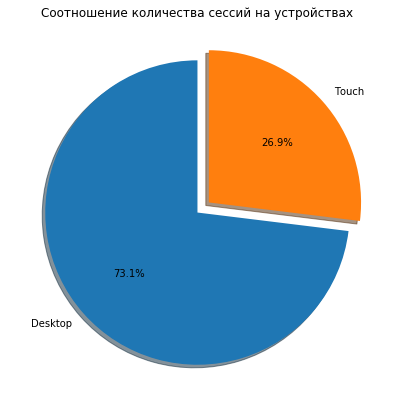

In [32]:
names = ['Desktop', 'Touch'] 
  
data = [desk_share,touch_share] 
  
fig = plt.figure(figsize =(10, 7)) 
explode = (0, 0.1)
plt.pie(data, labels = names, autopct='%1.1f%%',
        shadow=True, startangle=90, explode=explode) 
  
plt.title('Соотношение количества сессий на устройствах')
plt.show()

Несмотря на то, что в последнее время идет общий тренд на рост использования сервисов с мобильных устройств, около 73% всех сессий Яндекс.Афиши проходят на десктопе. Возможно, интерфейс мобильного сайта не очень удобен для пользователя, например, с точки зрения выбора мест на схемах больших концертных залов.

* **Сколько длится одна сессия?**

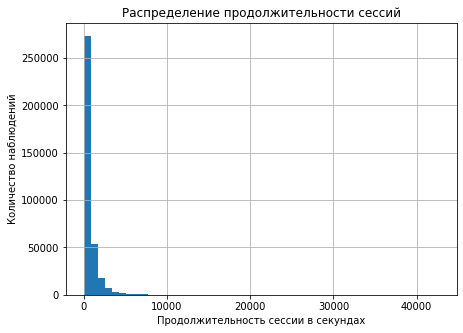

In [33]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['duration'].hist(bins=50, figsize=(7,5))
plt.xlabel('Продолжительность сессии в секундах')
plt.ylabel('Количество наблюдений')
plt.title('Распределение продолжительности сессий')
plt.show()

Распределение продолжительности сессий не имеет форму нормального распределения, а ближе к распределению Пуассона, значит, для рассчета средней продолжительности сессии будет целесообразно рассчитать наиболее часто встречаемое значение-моду.

In [34]:
visits['duration'].mode()

0    60
dtype: int64

Средняя продолжительность сессии составляет минуту. Достаточно мало для того, чтобы изучить график предстоящих мероприятий, выбрать желаемое и совершить покупку, однако, возможно, достаточно для того, чтобы совершить покупку билета, если переход был осуществлен по ссылке, которая направляла на покупку билета конкретного события.

In [35]:
len(visits.query('duration==0'))/len(visits)

0.09959432161559051

Около 10% сессий не имеют продолжительности, возможно это просто случайные переходы на сайт.

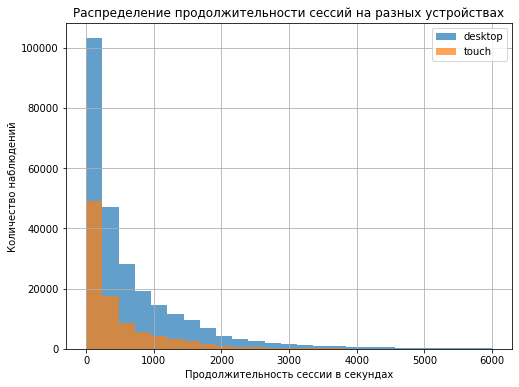

In [36]:
visits.groupby('device')['duration'].hist(figsize=(8,6), bins=25, range=(0,6000), alpha=0.7)
plt.legend(['desktop', 'touch'])
plt.xlabel('Продолжительность сессии в секундах')
plt.ylabel('Количество наблюдений')
plt.title('Распределение продолжительности сессий на разных устройствах')
plt.show()

In [37]:
visits.groupby('device')['duration'].apply(stats.mode)

device
desktop    ([60], [35411])
touch      ([60], [17618])
Name: duration, dtype: object

Средняя продолжительность сессии (мода) не различается в зависимости от используемого устройства. Возможно, выдвинутая ранее гипотеза о том, что мобильная версия сервиса менее удобна, чем версия для десктопа, может не подтвердиться. Причина популярности десктопа может крыться в чем-то другом: например, реклама настроена так, что больше привлекается трафика с десктопа.


* **Как часто люди возвращаются?**

In [38]:
#находим первую дату посещения для каждого id, присоединяем к таблице с посещениями
first_visit_date = visits.groupby(['uid'])['start_ts'].min()
first_visit_date.name = 'first_visit_date'
visits = visits.join(first_visit_date,on='uid') 

In [39]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,day,month,week,duration,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2,2017-12,51,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,0,2018-02,8,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,5,2017-07,26,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,6,2018-05,20,1440,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2,2017-12,52,0,2017-12-27 14:06:00


In [40]:
#сокращаем даты посещений и первых заходов до месяца
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

In [41]:
#рассчитываем возраст когорт
visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 

In [42]:
#создаем таблицу с датой когорты, ее вощрастом и численностью
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

In [43]:
#выделяем в каждой когорте изначальное число пользователей
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]

In [44]:
#переименовываем столбцы
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [45]:
#присоединяем к когортам первоначальное число пользователей
cohorts = cohorts.merge(initial_users_count,on='first_visit_month') 

In [46]:
#рассчитаем retention rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 


In [47]:
#строи сводную таблицу, заранее исключая нулевой возраст когорты для дальнейшей более наглядной визуализации
retention_pivot = cohorts.query('cohort_lifetime > 0').pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum') 

In [48]:
retention_pivot

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,
2017-06-01,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


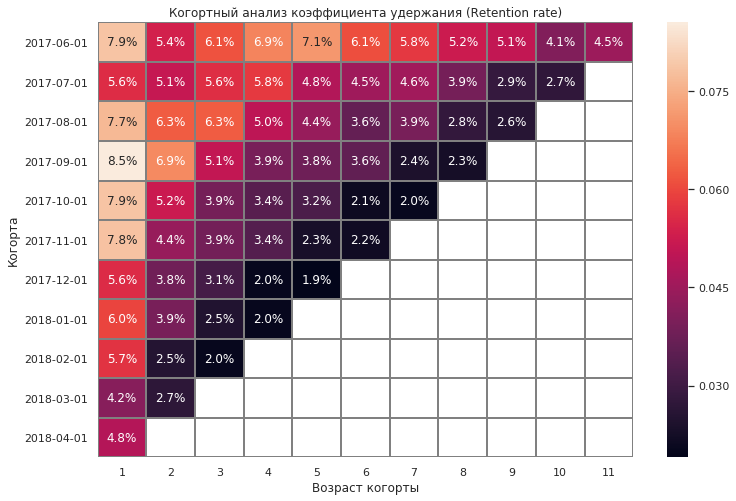

In [49]:
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Когортный анализ коэффициента удержания (Retention rate)')
ax=sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 
ax.set_yticklabels(retention_pivot.index.strftime('%Y-%m-%d') )
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Больше всего пользователей в первый месяц вернулось в сентябрьской когорте. В целом, лучше всего себя проявлет июньская когрта, даже на 11 месяц ее жизни вернулось около 4.5%, в то время, как в остальных когортах в последние периоды возвращалось около 2% пользователей. Июньская когорта может демонстрировать себя лучше других по возвращению пользователей по ряду причин: например, в этот период настройки таргетинга были настроены лучше, в следствие чего привлекалась качественная целевая аудитория, или же было выбрано наиболее оптимальное распределение рекламного бюджета между источниками рекламы, что в свою очередь также привлекло наиболее качественный трафик. Наиболее молодые когорты в первый месяц по сравнению с более взрослыми хуже демонстрируют себя в части возвращения пользователей. Предположить о том, что каким-то образом изменился интрфейс-сервиса, навряд и можно, так как если рассматривать июньскую когорту, то даже на одиннадцатый месяц её жизни коэффициент удержания пользователей выше, чем в первый месяц жизни мартовской когорты. 

### Вывод

* среднее количество пользователей в день (DAU): 908;
* среднее количество пользователей в неделю (WAU): 5825;
* среднее количество пользователей в месяц (MAU): 23228;
* средняя продолжительность сессии составляет 1 минуту;
* около 73% всех сессий приходится на десктоп;
* в первый месяц возвращается от 4.2% до 8.5% в зависимости от даты образования когорты;
* по возвращению пользователей - лучше всего себя проявлет июньская когорта, вероятно в период привлечения её пользователей использовались наиболее эффективные интсрументы привлечения целевой аудитории, возможно стоит более подробно изучить данную когорту-выяснить, что объединяет данных пользователей, чтобы в дальнейшем применить это знание для последующих рекламных кампаний;
* в целом, даже максимально достигнутый коэффициент удержания пользователей -8,5% нельзя назвать достаточно высоким, а  коэффициент удержания молодых когорт имеет тенденцию снижения.

### Продажи

* **Когда люди начинают покупать?**

In [50]:
#рассчитаем дату первого заказа для каждого клиента, совершавшего покупки
first_order = orders.groupby('uid')['buy_ts'].min().reset_index()  
first_order.columns=['uid','first_buy_date']

In [51]:
len(first_order)/len(first_visit_date)*100

16.006994815246596

Видим, что только около 16% клиентов, заходивших на сайт сервиса, совершали на нем покупку.

In [52]:
#создадим таблицу с пользователями и первой датой их покупки  и захода на сайт
orders_new = pd.merge(first_visit_date,first_order, on='uid')

In [53]:
orders_new.head()

,uid,first_visit_date,first_buy_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [54]:
#проверим есть ли несостыковки по времени в полученной таблице
len(orders_new.query('first_visit_date>first_buy_date'))

0

In [55]:
#рассчитаем сколько прошло времени с момента первого посещения сервиса до первой совершенной покупки
orders_new['diff']=(orders_new['first_buy_date']-orders_new['first_visit_date'])

In [56]:
#приведем время между первым заходом на сайт и первой покупкой в минуты
orders_new['diff']=orders_new['diff']/np.timedelta64(1, 'm')
orders_new['diff']=orders_new['diff'].round(1)

In [57]:
orders_new.head()

,uid,first_visit_date,first_buy_date,diff
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


In [58]:
orders_new['diff'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: diff, dtype: float64

In [59]:
len(orders_new.query('diff==0'))/len(orders_new)

0.06721791747665855

Четверть пользователей совершают покупку через 4 минуты и менее, при этом около 6.7% всех пользоватлей совершают покупку сразу в момент перехода на сервис, скорее всего это пользователи перешедшие по ссылке, которая вела сразу на покупку билета на конкретное мероприятие. Половина пользователей совершает покупку за 16 минут и менее.

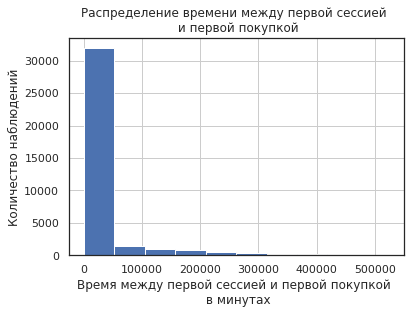

In [60]:
(orders_new['diff']).hist()
plt.xlabel('Время между первой сессией и первой покупкой \n в минутах')
plt.ylabel('Количество наблюдений')
plt.title('Распределение времени между первой сессией \n и первой покупкой')
plt.show()

Распредление имеет форму Пауссона, а значит среднее значение будет лучше отображать мода.

In [61]:
(orders_new['diff']).mode()

0    1.0
dtype: float64

В среднем с момента первого захода на сайт до совершения покупки проходит 1 минута, что равняется средней продолжительности сессии. Скорее всего наибольшая часть пользователей, попадает на сайт впервые в момент покупки билета на конкретное мероприятие через ссылку, которая сразу направляет на страницу оплаты.


* **Сколько раз покупают за период?**

In [62]:
orders['date']= orders['buy_ts'].dt.date
orders['week'] = orders['buy_ts'].dt.week
orders['month'] = orders['buy_ts'].dt.month

In [63]:
orders.groupby('date')['uid'].count().mean()

138.50274725274724

В день в среднем совершается 139 покупок.

In [64]:
orders.groupby('week')['uid'].count().mean()

969.5192307692307

В неделю в среднем совершается 970 покупок.

In [65]:
orders.groupby('month')['uid'].count().mean()

4201.25

В месяц совершается в среднем 4201 покупка.

Рассчитаем как изменяется количество покупок в каждой когорте в расчете на одного пользователя.

In [66]:
#создаем когорты по первой дате покупки и присоединяем к таблице с заказами
first_order = orders.groupby('uid')['buy_ts'].min().reset_index()
first_order.columns = ['uid', 'date_of_first_order']
order_number = pd.merge(orders, first_order, on='uid')
order_number['date_of_first_order']=order_number['date_of_first_order'].astype('datetime64[M]')
order_number.head(10)

,buy_ts,revenue,uid,date,week,month,date_of_first_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,22,6,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,22,6,2017-06-01
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-05,23,6,2017-06-01
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,22,6,2017-06-01
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-02,22,6,2017-06-01


In [67]:
#рассчитаем для каждой когорты
from dateutil import relativedelta
from dateutil.relativedelta import relativedelta
order_number['diff']=order_number.apply(lambda x: relativedelta(x['buy_ts'], x['date_of_first_order']).months, axis=1)


In [68]:
#рассчитаем для каждой когорты её возраст
order_number['cohort_lifetime'] = order_number['buy_ts'] - order_number['date_of_first_order']
order_number['cohort_lifetime'] = order_number['cohort_lifetime'] / np.timedelta64(1,'M')
order_number['cohort_lifetime'] = order_number['cohort_lifetime'].astype('int') 
order_number.head()

,buy_ts,revenue,uid,date,week,month,date_of_first_order,diff,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017-06-01,0,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017-06-01,0,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017-06-01,0,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017-06-01,0,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017-06-01,0,0


In [69]:
order_by_cohorts = order_number.groupby(['date_of_first_order','cohort_lifetime']).agg({'buy_ts': 'count', 'uid': 'nunique'})
                            
order_by_cohorts['order_per_user'] = order_by_cohorts['buy_ts']/order_by_cohorts['uid']
order_by_cohorts = order_by_cohorts.reset_index()
order_by_cohorts.head()

,date_of_first_order,cohort_lifetime,buy_ts,uid,order_per_user
0,2017-06-01,0,2357,2023,1.165101
1,2017-06-01,1,173,59,2.932203
2,2017-06-01,2,166,50,3.320000
3,2017-06-01,3,235,57,4.122807
4,2017-06-01,4,286,87,3.287356


In [70]:
order_number_pivot = order_by_cohorts.pivot_table(index='date_of_first_order', columns='cohort_lifetime', values='order_per_user')

In [71]:
order_number_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
date_of_first_order,,,,,,,,,,,,
2017-06-01,1.165101,2.932203,3.320000,4.122807,3.287356,3.220588,4.516129,3.510638,3.900000,3.279070,2.177778,1.584906
2017-07-01,1.136267,1.654762,2.105263,1.650794,1.403846,2.153846,1.757576,1.255814,1.380952,1.090909,2.038462,NaN
2017-08-01,1.115119,1.524590,1.836364,1.860465,2.128205,1.968750,1.696970,1.720930,2.473684,1.500000,NaN,NaN
2017-09-01,1.137156,1.682171,1.610000,2.232877,1.288462,1.661972,1.694915,1.513514,1.418605,NaN,NaN,NaN
2017-10-01,1.141402,1.417957,1.314516,1.318182,1.424242,1.405797,1.553571,1.878788,NaN,NaN,NaN,NaN
2017-11-01,1.180103,1.802752,1.508475,1.982759,1.648649,1.220000,1.639344,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152586,1.501946,2.018018,1.787234,1.705882,1.677419,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.120062,1.507692,1.883117,1.558140,1.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.128184,1.914286,1.366667,1.837838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


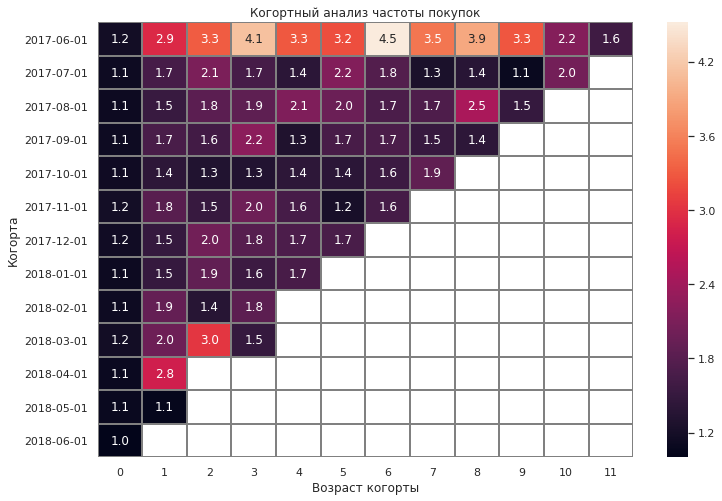

In [72]:
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Когортный анализ частоты покупок')
ax=sns.heatmap(order_number_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray'); 
ax.set_yticklabels(order_number_pivot.index.strftime('%Y-%m-%d') )
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

На тепловой карте мы видим, что практически во всех когортах (за исключением двух последних), после своершения первой покупки в нулевой месяц, в следующем месяце среднее число покупок приходящихся на одного пользователя увеличивается. И снова выделяется июньская когорта, пользователи которой не только лучше остальных возвращаются к сервису, но и в большей степени чем остальные совершают покупки чаще. В июне 2017 года, скорее всего, удалось привлечь очень качественную аудиторию, необходимо детальнее изучить её особенности, а также рассмотреть какие инструменты маркетинга использовались для её привлечения.

* ***Какой средний чек?***

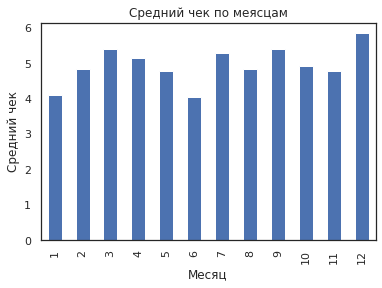

In [73]:
orders.groupby('month').agg({'revenue': 'mean'}).plot(kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.title('Средний чек по меясцам')
plt.legend().remove()
plt.show()

In [74]:
monthly_revenue=orders.groupby('month').agg({'revenue': 'mean'}).reset_index()

In [75]:
monthly_revenue['revenue'].describe()

count    12.000000
mean      4.956902
std       0.521307
min       4.059834
25%       4.780459
50%       4.887709
75%       5.333424
max       5.852139
Name: revenue, dtype: float64

Наибольший средний чек наблюдается в декабре, вероятно в это время люди покупают больше билетов на мероприятия в новогодние каникулы, при этом как правило цены за счет высокого спроса в этот преиод на мероприятия увеличиваются. Cредний чек за период составляет примерно 4.89 условных единиц (в пояснении к данным не указаны единицы измерения)

In [76]:
#создаем когорты по первой дате заказа,для каждой кагорты рассчитываем её численность в каждый месяц и суммарную выручку
first_order = orders.groupby('uid')['buy_ts'].min()
first_order.name = 'first_order_month'
orders = orders.join(first_order,on='uid')
orders['first_order_month'] = orders['first_order_month'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})

In [77]:
orders_grouped_by_cohorts.head()

revenue   uid
first_order_month order_month               
2017-06-01        2017-06-01   9557.49  2023
                  2017-07-01    981.82    61
                  2017-08-01    885.34    50
                  2017-09-01   1931.30    54
                  2017-10-01   2068.58    88

In [78]:
#рассчитываем средний чек
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid'] 

In [79]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
#рассчитываем возраст для когорты
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')


In [80]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')

revenue_per_user_pivot

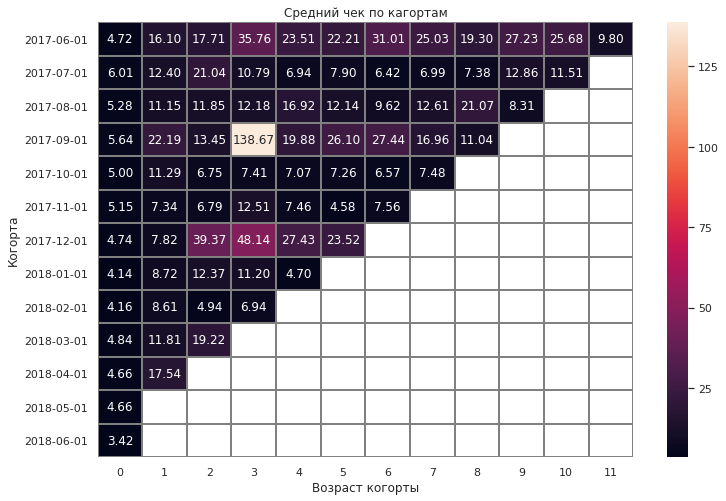

In [81]:
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Средний чек по кагортам')
ax=sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 
ax.set_yticklabels(revenue_per_user_pivot.index.strftime('%Y-%m-%d') )
plt.ylabel('Когорта')
plt.xlabel('Возраст когорты')
plt.show()

На тепловой карте значительно выделяется сентябрьская когорта на 3 месяц, возможно в данный период для её пользователей проводилась выгодная акция. Необходимо изучить почему было такое резкое увелечение среднего чека у данных пользователей. Также мы видим значительный рост у декабрьской когорты начиная со 2 месяца её жизни. Вероятно стоит соспоставить выводы о сентябрьской и декабрьской когорте в периоды, когда у них произошло значительное увелечинение среднего чека.

* **Сколько денег приносят? (LTV)**

In [82]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

In [83]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Сократим период заказов на один день, чтобы он совпадал с периодом расходов.

In [84]:
orders_q=orders.query('buy_ts<="2018-05-31 00:00:00"')

In [85]:
orders_q.head()

,buy_ts,revenue,uid,date,week,month,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017-06-01,2017-06-01


In [86]:
#определяем дату первого заказа для каждого пользователя
first_orders=orders_q.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [87]:
#рассчитываем количество пользоватедей в каждой кагорте
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [88]:
orders_new = pd.merge(orders_q,first_orders, on=['first_order_month','uid'])
orders_new.head()

,buy_ts,revenue,uid,date,week,month,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017-06-01,2017-06-01


In [89]:
#формируем когорты с выручкой за каждый месяц
cohorts = orders_new.groupby(['order_month','first_order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,order_month,first_order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-07-01,2017-06-01,981.82
2,2017-07-01,2017-07-01,11557.65
3,2017-08-01,2017-06-01,885.34
4,2017-08-01,2017-07-01,644.61


In [90]:
#добавляем численность когорты
report = cohorts.merge(cohort_sizes, on='first_order_month')
report.head()

,order_month,first_order_month,revenue,n_buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-07-01,2017-06-01,981.82,2023
2,2017-08-01,2017-06-01,885.34,2023
3,2017-09-01,2017-06-01,1931.30,2023
4,2017-10-01,2017-06-01,2068.58,2023


In [91]:
#рассчитаем возраст когорты
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

Для расчета LTV используется маржинальная прибыль, однако в заданных условиях у нас не задан уровень маржинальности, поэтому по умолчанию будем считать его равным 100%. В случае уточнения точного уровня маржинальности, нам не составит труда посчитать маржинальную прибыль и пересчитать LTV.

In [92]:
#рассчитываем LTV (при условии что маржинальность равна 100%)
report['ltv'] = report['revenue'] / report['n_buyers']

In [93]:
#строим сводную таблицу по когортам
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.02253,0.735502,0.95044,0.581592,0.553213,0.605788,0.571261,0.247855
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.14182,0.161232,0.147145,0.142673,
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664,0.405007,0.292212,0.131774,,
2017-09-01,5.644529,1.11759,0.52093,3.97579,0.400558,0.647067,0.701608,0.24315,0.165134,,,
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.0848157,0.104558,,,,
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.111066,,,,,
2017-12-01,4.738191,0.260374,0.925097,1.06527,0.31293,0.331561,,,,,,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.0572221,,,,,,,
2018-02-01,4.156987,0.278274,0.0785155,0.0688551,,,,,,,,


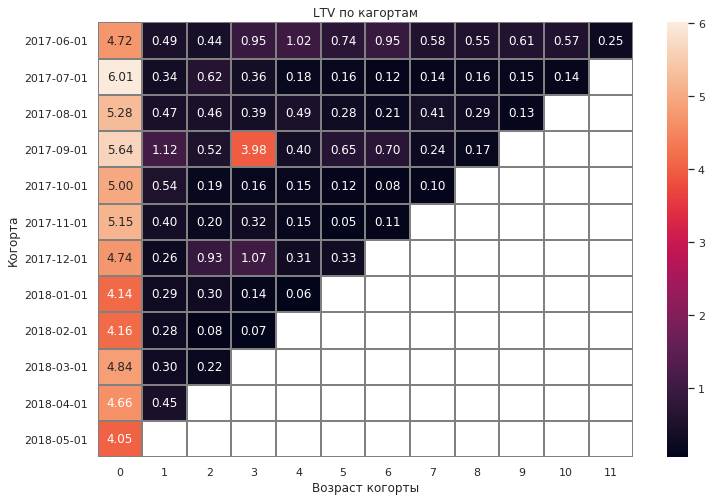

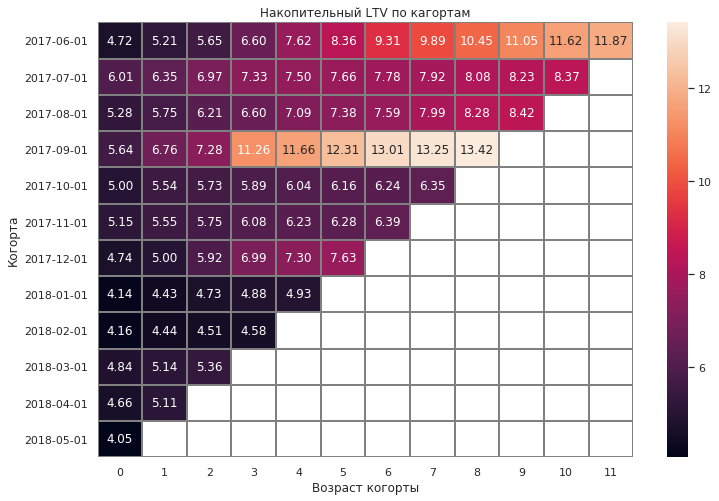

In [94]:
#визуализируем полученный результат, добавляя тепловую карту по накопленному LTV
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('LTV по кагортам')
ax=sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 
ax.set_yticklabels(output.index.strftime('%Y-%m-%d') )
plt.ylabel('Когорта')
plt.xlabel('Возраст когорты')
plt.show()

cum=output.cumsum(axis=1)
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Накопительный LTV по кагортам')
ax=sns.heatmap(cum, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 
ax.set_yticklabels(cum.index.strftime('%Y-%m-%d') )
plt.ylabel('Когорта')
plt.xlabel('Возраст когорты')
plt.show()

Наиболее успешный и стабильный показатель LTV вновь наблюдается у июньской когорты, это объясняется тем, что у неё был относительно хороший показатель частоты покупок при неплохом среднем чеке. Помимо этого стоит отметить что в сентябрьской когорте на 3 месяц её жизни наблюдается значительный рост LTV, который был достигнут засчет резкого увеличения среднего чека, а также наиболее высокой частоты совершаемых покупок, которая достигла наибольшего значения в этот период в данной когорте.

### Вывод

* пользователи не склонны проводить много времени на сайте, чаще всего покупка совершается за 1 минуту, что может говорить о том, что они непосредственно попадают на страницу оплаты уже заранее выбранного мероприятия;
* наблюдается позитивная динамика частоты покупок с течением времени, когорты пользователей склонны совершать покупки чаще после своего первого приобретения на сайте;
* значительный рост среднего чека наблюдается у сентябрьской когорты на 3 месяце ее жизни, необходимо изучить, что могло поспособствовать подобному потребительскому поведению, для того, чтобы использовать это в дальнейшем для других пользователей;
* наиболее успешный и стабильный показатель LTV наблюдается у июньской когорты, это объясняется тем, что у неё был относительно хороший показатель частоты покупок при неплохом среднем чеке, необходимо также проанализировать что объединяет пользователей данной когорты и выделяет её среди остальных

### Маркетинг

* **Сколько денег потратили? Всего / на каждый источник / по времени**

In [95]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [96]:
total=costs['costs'].sum()
total

329131.62

In [97]:
data_costs=costs.groupby('source_id').agg({'costs':'sum'}).sort_values(by='costs',ascending=False).reset_index()

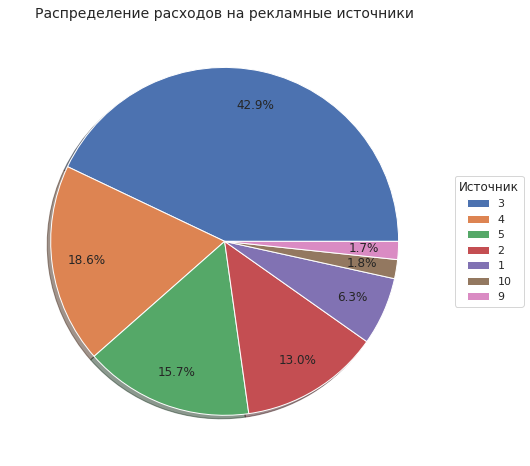

In [98]:
data_costs['share']=data_costs['costs']/total*100
plot = data_costs.plot.pie(y='share', figsize=(8, 8), labels=None,autopct='%1.1f%%', pctdistance=0.8,textprops={'fontsize': 12},shadow=True)
plot.legend(data_costs['source_id'],title="Источник", loc="center right",bbox_to_anchor=(1, 0, 0.2, 1))
plt.ylabel('')
plt.title('Распределение расходов на рекламные источники', fontsize=14)
plt.show()

Всего за год на рекламу было потрачено 329131.62. Наибольшая часть бюджета в размере 42.9% была потрачена на источник номер 3. Около 18.6% была израсходовано на 4 источник. Примерно одинаковые расходы (с разницой в 2.7%) были на источники номер 5 и 2. Меньше всего тратилось на источник номер 9 и 10.

In [99]:
costs['month']=costs['dt'].astype('datetime64[M]')

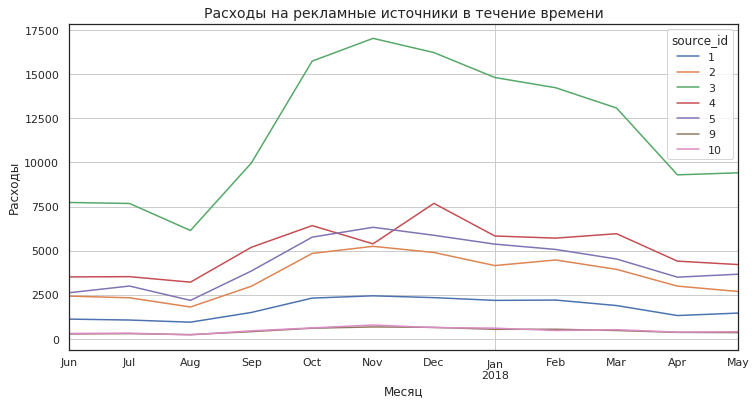

In [100]:
graph=costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum').plot(figsize=(12,6),grid=True)
plt.ylabel('Расходы')
plt.xlabel('Месяц')
plt.title('Расходы на рекламные источники в течение времени', fontsize=14)
plt.show()


Рост расходов практически на все рекламные источники продолжался в период с сентября по ноябрь. Расходы на четвертый источник сократились в ноябре, однако в декабре на него траты снова увеличились. Для остальных источников начиная с декабря наблюдается общий тренд снижения расходов.

* **Сколько стоило привлечение одного покупателя из каждого источника?**

In [101]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [102]:
#сгруппируем расходы по источникам и рассчитаем для них суммарные затраты за весь период
cost_g=costs.groupby(['source_id','month'])['costs'].sum().reset_index()

In [103]:
cost_g

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
...,...,...,...
79,10,2018-01-01,614.35
80,10,2018-02-01,480.88
81,10,2018-03-01,526.41
82,10,2018-04-01,388.25


In [104]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,day,month,week,duration,first_visit_date,first_visit_month,visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2,2017-12,51,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,0,2018-02,8,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,5,2017-07,26,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,6,2018-05,20,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2,2017-12,52,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


In [105]:
#добавляем в таблицу с посещениями даты первых заказов
first_order = orders.groupby('uid')['buy_ts'].min()
first_order.name = 'first_order_date'
visits=visits.join(first_order, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,date,day,month,week,duration,first_visit_date,first_visit_month,visit_month,cohort_lifetime,first_order_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2,2017-12,51,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0,NaT
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,0,2018-02,8,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0,NaT
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,5,2017-07,26,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0,NaT
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,6,2018-05,20,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01,2,2018-03-09 20:25:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2,2017-12,52,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0,NaT


In [106]:
users=visits[['uid','source_id','date','first_order_date']]
users['first_order_date']=users['first_order_date'].dt.date
users=users[users['date']==users['first_order_date']]
users=users.merge(orders.groupby('uid')['revenue'].sum(), on='uid',how='left')
users=users.dropna().reset_index(drop=True)
users

,uid,source_id,date,first_order_date,revenue
0,18188358787673499603,2,2018-02-12,2018-02-12,0.79
1,15857957287537270437,3,2018-03-12,2018-03-12,1.83
2,15868686231870595097,5,2018-03-27,2018-03-27,1.95
3,9344114199116964256,5,2018-02-25,2018-02-25,0.98
4,14063997464143962003,4,2018-01-25,2018-01-25,1.22
...,...,...,...,...,...
37905,18363291481961487539,2,2017-07-29,2017-07-29,2.68
37906,18370831553019119586,1,2018-01-25,2018-01-25,3.30
37907,18387297585500748294,4,2018-03-03,2018-03-03,0.61
37908,18388616944624776485,5,2017-11-02,2017-11-02,2.69


In [107]:
users['first_order_month']=users['first_order_date'].astype('datetime64[M]')

In [108]:
#создаем таблицу с источниками их количеством покупателей, затратами на рекламу и выручкой для каждого месяца
rev_source=users.groupby(['source_id','first_order_month']).agg({'uid':'count','revenue':'sum'}).reset_index()
rev_source.columns=['source_id','month','users','revenue']
rev_source=rev_source.merge(cost_g, on=['source_id','month'])
rev_source.head()

,source_id,month,users,revenue,costs
0,1,2017-06-01,302,9587.36,1125.61
1,1,2017-07-01,303,4369.54,1072.88
2,1,2017-08-01,191,2486.31,951.81
3,1,2017-09-01,362,3627.01,1502.01
4,1,2017-10-01,566,4843.57,2315.75


In [109]:
#рассчитываем стоимость привлечения одного покупателя
rev_source['cac']=rev_source['costs']/rev_source['users']

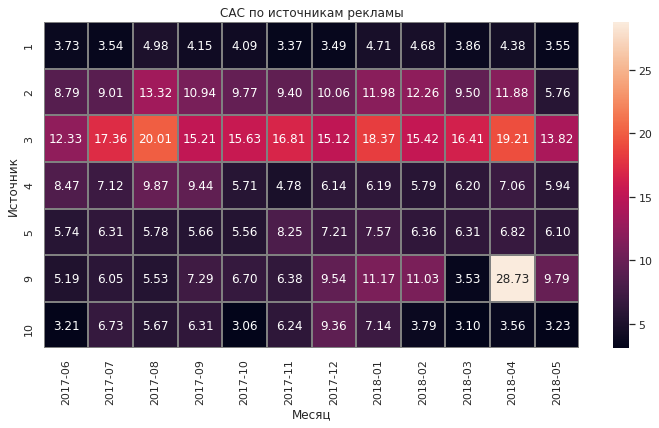

In [110]:
source_pivot=rev_source.pivot_table(index='source_id', columns='month', values='cac',aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(12, 6))
plt.title('САС по источникам рекламы')
ax=sns.heatmap(source_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 
ax.set_xticklabels(source_pivot.columns.strftime('%Y-%m') )
plt.ylabel('Источник')
plt.xlabel('Месяц')
plt.show()

Наиболее дорогими оказались покупатели из источника номер 3, а самые дорогие покупатели были из 9 источника в апреле. Стоит отметить, что наиболее дешевым в привлечении покупателей оказался источник 1.

* **На сколько окупились расходы?**

In [111]:
rev_source['romi']=rev_source['revenue'] /rev_source['costs']

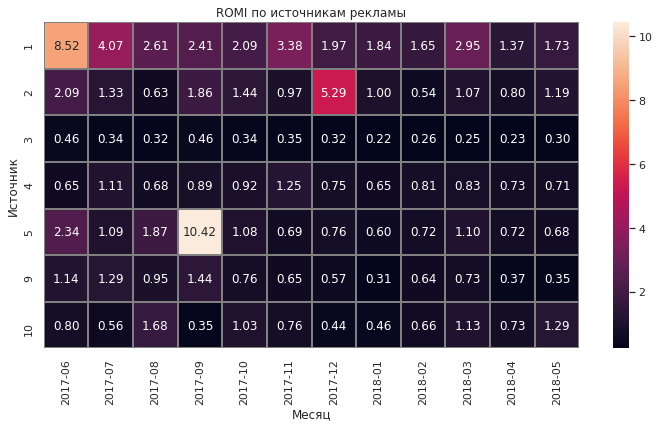

In [112]:
romi_pivot=rev_source.pivot_table(index='source_id', columns='month', values='romi',aggfunc='mean' )

sns.set(style='white')
plt.figure(figsize=(12, 6))
plt.title('ROMI по источникам рекламы')
ax=sns.heatmap(romi_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 
ax.set_xticklabels(romi_pivot.columns.strftime('%Y-%m') )
plt.ylabel('Источник')
plt.xlabel('Месяц')
plt.show()

Как мы можем увидеть из тепловой карты, самым неокупаемым источником оказался третий, а на него тратилось больше 40% рекламного бюджета. На регулярной основе окупается первый источник стабильно принося доход сервису. Также стоит отметить самую высокую окупаемость у пятого источника в сентябре. 

## Общие выводы и рекомендации<a id="step5"></a> 

* средняя продолжительность сессии составляет 1 минуту, примерно за это же время большинство пользователей совершает покупку, что скорее всего свидетельствует о том, что пользователи по ссылке попадают сразу на страницу покупки билета на конкретное мероприятие. Таким образом пользователи пользуются сервисом в основном только как посредником по продаже и не задерживаются на сайте для поиска и выбора меропрития; 

* около 73% всех сессий приходится на десктоп, на мобтльные девайсы остается весьма небольшая доля принимая во внимание тот факт, что мобильный трафик имеет тенденцию роста в использовании интернета в последнее время. Подобная низкая доля мобильного трафика может объсняться тем, что у сервиса есть приложение только для iOS, и не имеяя версии приложения для андроида,возможно, теряет потенциальных пользоватлей;

* в целом, даже максимально достигнутый коэффициент удержания пользователей -8,5% нельзя назвать достаточно высоким, а  коэффициент удержания молодых когорт имеет тенденцию снижения;

* однако наблюдается позитивная динамика частоты покупок с течением времени, когорты пользователей склонны совершать покупки чаще после своего первого приобретения на сайте;

* для того, чтобы лучше понять свою целевую аудиторию необходимо более подробно изучить когрту пользователей, которая пришла в июне. Для неё характерны наиболеее высокий коэффициент удержания, хороший и стабильный LTV благодаря хорошему показателю частоты покупок при неплохом среднем чеке. Привлечение пользователей, похожих на июньскую когорту, поможет принести сервису значительно больше прибыли;

* что касается распределения рекламного бюджета, его необходимо пересмотреть, более 40% было израсходовано на источник 3, при этом за весь период он ни разу не окупился. Стоит выделить больше денег на источник 1, так как он имеет стабильную хорошую окупаемость. Также стоит отметить самую высокую окупаемость у пятого источника в сентябре, необходимо детально изучить рекламную кампанию данного источника в этот преиод, возможно удастся понять причины успеха и применить их в дальнейшем.
